- 1个配送中心和8个顾客点
- 配送2种产品
- 配送中心拥有3辆可供调配的车
- 每条路的路况异质化，变化趋势由48个变化时段构成

- 1.在Excel中的第一列写入1个配送中心和8个顾客点的地理位置的X轴坐标；第二列写入1个配送中心和8个顾客点的地理位置的Y轴坐标
- 2.在Excel中的第三列写入1个配送中心和8个顾客点对产品的需求（kg），其中配送中心对产品的需求写为0。ps:这里可以计算所以顾客点对产品的需求的和再除以车的数目，以便于后面设置车辆的容量。

In [1]:
#导入工具包
import datetime
import math   #即可使用sin、cos等函数
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
from matplotlib.font_manager import FontProperties
import random 
random.seed(123) 

In [2]:
#在Jupyter Notebook中加载memory_profiler扩展来测量代码单元的内存使用情况
%load_ext memory_profiler

In [3]:
#初始化函数，为主函数传入全部可以知道的固定的已知变量
def init(n, m):
    
    """
    初始化函数，包括读取坐标数据，计算两位置之间距离矩阵，设定初始路径等
    :param n: n为顾客点数
    :param m: m为可调度车辆数量
    :return: 返回初始路径、初始出发时刻、距离矩阵、每个节点对各类产品的需求、每条路的交通态势信息
    """
        #利用xlrd模块来读取excel中的某一列的数据并返回
    def get_data():
        data = pd.read_excel(r'E:/my first paper code/05.优化算法/Location_and_Demand.xlsx',header=None ,engine='openpyxl') # 打开选择的excel表格，将之赋给data
        return list((data.iloc[:,0:1].values).flatten()), list((data.iloc[:,1:2].values).flatten()),list((data.iloc[:,2:3].values).flatten()),list((data.iloc[:,3:4].values).flatten())#返回Excel中所有列数据
  
    node_x, node_y, qp1,qp2= get_data()  # 读取配送中心和顾客点的坐标点、及每个点对产品的需求量，其中配送中心对产品的需求为0
    
#*****************************************************************************************************************************
    
    #根据配送中心和顾客点的地理位置坐标点，计算距离矩阵（二维列表）
    D = [[0 for _ in range(n+1)] for _ in range(n+1)]  # 定义有n+1个元素的二维列表，用于保存节点之间的距离
    for i in range(len(node_x)):
        for j in range(len(node_x)):
            D[i][j] = round(np.sqrt((node_x[i] - node_x[j]) ** 2 + (node_y[i] - node_y[j]) ** 2))  # 循环遍历全部路径，计算每条路之间的距离
    
    #生成初始的每个车辆从配送中心出发的时刻列表
    init_departTime = [480]*m  #创建了具有m个480元素的列表，用于定义一维出发时刻的解空间,这里同时也是初始解 
    
    #生成初始的路径的列表
    init_path = [0 for _  in range(n + m + 1)]  # 创建了具有n + m + 1个0元素的列表，用于定义一维路径的解空间
    
    #生成路径初始解，这里面包含m+1个序号0（代表配送中心）和序号1~n（代表每个顾客点）。m+1个0将一维路径列表分成m段，即代表m辆车的行驶路线
    for i in range(m):
        init_path[i] = 0
    for j in range(n):
        init_path[j + m] = j + 1 
    
    #传入其他单一定值
    v_f = 0.83   #车在自由流下的速度，单位：千米/分钟
    C_d = 0.7   #空气动力阻力系数
    rou_air = 1.29  #空气密度：标准条件下，空气密度为1.29KG/m^3，单位：千克/立方米
    A = 3.912  #单位：平方米
    W = 6350  #车空载时的重量，即车本身的重量，单位：千克
    g = 9.81   #重力加速度，单位：米/二次方秒
    C_r = 0.01  #滚动阻力系数
    theta_ij = [[0, 0, 0, 0, 0, 0, 0, 0, 0], #每条道路的角度,第几行是i，第几列是j，由于是城市道路，道路均比较平坦，所以道路角度设置为1
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0]]
    K = 0.2   #发动机摩擦系数，单位：千焦/转/升
    Ne = 33   #发动机转速，单位：转/秒
    V = 5     #发动机排量，单位：升 
    epsilon = 0.4   #车辆传动系统效率
    eta = 0.9     #柴油机的效率参数  
    ksi = 1 #燃料空气质量比 
    kappa = 44  #典型柴油的热值，单位：千焦/克
    psai = 737   #单位换算系数
    T_goal = 291.15 #冷藏车的目标温度，这里随便设置它等于10。当车辆所运输的产品的种类是确定的，则这个目标温度应该是确定的，取三者都同时适合的温度
    T_out = 301.15  #车外温度，是一个恒定的温度，单位：开尔文
    S = 150  #车的表面积
    U = 0.44    #热量传递系数
    tau = 0.013  #工人卸载速率，小于1，单位：分钟/千克
    v_incrs = 0.0027  #温度上升的速率
    V_K = 50  #车辆的体积
    HCA = 1000  #空气的容积热容量
    ECF = 33000000
    eta_e = 0.4
    COP = 0.5
    Q_0 = 1  #产品的初始质量
    lamuda = [0.002,0.003] #不同产品的衰减系数
    C=[3,2]  #不同产品的成本，单位：元/千克
    fuel_cost = 9.82 #燃油成本，单位：元/升
    tci_end_ijh = [[[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440]],
                   [[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440]],
                   [[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440]],
                   [[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440]],
                   [[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440]],
                   [[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440]],
                   [[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440]],
                   [[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440]],
                   [[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440],
                    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440]]]
    
    #异质性拥堵-2018年11月23日Dlinear预测数据
    
    tci_ijh=[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 7, 7, 6, 7, 6, 7, 7, 6, 6, 5, 5, 5, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 7, 6, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 8, 8, 7, 7, 7, 8, 8, 9, 8, 9, 8, 9, 9, 9, 10, 9, 9, 9, 10, 10, 10, 10, 10, 9, 9, 7, 7, 5, 4, 4, 4, 3, 3, 4, 4, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 5, 5, 6, 6, 8, 8, 7, 8, 9, 8, 8, 9, 8, 8, 8, 7, 6, 5, 4, 4, 3, 3, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 8, 8, 9, 7, 8, 6, 7, 6, 6, 6, 6, 6, 7, 7, 7, 6, 5, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 5, 6, 6, 6, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
              [2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 9, 9, 9, 9, 9, 8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 5, 5, 6, 5, 6, 5, 5, 5, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2]],
             [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 5, 4, 4, 5, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 7, 7, 7, 7, 7, 7, 6, 5, 5, 5, 4, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 3, 3, 4, 3, 2, 2, 3, 3, 2, 1, 1, 1, 1, 1, 1, 2, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 7, 6, 7, 7, 7, 6, 6, 7, 8, 7, 7, 7, 6, 7, 7, 7, 6, 6, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 6, 5, 5, 6, 6, 6, 5, 6, 6, 7, 7, 7, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 6, 6, 6, 5, 6, 6, 7, 7, 8, 7, 8, 7, 7, 7, 7, 6, 6, 5, 5, 6, 6, 7, 6, 5, 5, 4, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 5, 4, 4, 5, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 7, 7, 7, 7, 7, 7, 6, 5, 5, 5, 4, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [4, 5, 4, 4, 4, 5, 5, 5, 6, 6, 5, 5, 4, 4, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 3, 2, 2, 2, 3, 3, 3, 3, 4, 5, 4, 5, 5, 5, 5, 4, 4, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 6, 6, 6, 8, 7, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 5, 5, 5, 5, 6, 6, 5, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 9, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 5, 6, 6, 5, 5, 4, 4, 4, 4, 4], 
              [1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 6, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1], 
              [1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 5, 5, 4, 5, 4, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 4, 5, 4, 4, 4, 4, 4, 5, 5, 4, 5, 6, 5, 5, 5, 5, 6, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 5, 5, 5, 5, 6, 6, 7, 6, 7, 6, 7, 5, 6, 6, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 7, 6, 5, 5, 4, 4, 4, 4, 3, 3, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 
             [[2, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 4, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 7, 7, 7, 6, 6, 7, 6, 6, 6, 6, 6, 5, 5, 6, 6, 7, 7, 7, 8, 7, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 6, 7, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 8, 8, 8, 9, 8, 9, 9, 8, 9, 9, 9, 8, 8, 8, 7, 7, 8, 8, 7, 7, 7, 7, 7, 6, 7, 6, 6, 6, 6, 6, 5, 5, 6, 6, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2], 
              [1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 5, 5, 5, 5, 4, 4, 5, 5, 4, 4, 5, 4, 4, 4, 3, 4, 3, 4, 4, 4, 5, 5, 5, 4, 5, 4, 4, 4, 4, 5, 4, 5, 5, 5, 5, 4, 4, 5, 5, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 7, 8, 7, 6, 6, 6, 7, 7, 7, 6, 6, 5, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 6, 8, 8, 8, 8, 8, 7, 7, 6, 6, 5, 5, 6, 5, 5, 5, 6, 6, 6, 6, 6, 5, 6, 5, 6, 5, 5, 5, 5, 5, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 4, 4, 4, 4, 5, 5, 4, 5, 5, 4, 5, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3], 
              [1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 5, 5, 5, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 3, 4, 3, 3, 4, 4, 4, 5, 4, 3, 4, 3, 4, 4, 4, 5, 4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 3, 3, 3, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 4, 5, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 3, 3, 3, 4, 4, 4, 3, 4, 3, 4, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 3, 4, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
             [[2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
              [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
              [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1], 
              [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 3, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 5, 4, 5, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 
             [[3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 6, 5, 6, 5, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 5, 5, 5, 5, 4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 4, 4, 4, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3], 
              [1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 2, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 4, 4, 4, 4, 4, 5, 5, 5, 5, 4, 5, 5, 4, 5, 4, 4, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 4, 4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 4, 4, 4, 3, 3, 4, 3, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1], 
              [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 4, 5, 5, 4, 4, 5, 5, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 7, 7, 7, 7, 6, 7, 7, 6, 6, 7, 7, 6, 7, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 7, 7, 7, 8, 8, 7, 7, 8, 7, 7, 8, 7, 7, 8, 8, 8, 7, 7, 7, 8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
              [2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5, 5, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], 
             [[3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3],
              [2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2], 
              [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 5, 5, 5, 4, 4, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 4, 4, 3, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2], 
              [2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2],
              [2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 6, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 4, 5, 6, 6, 6, 5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 6, 6, 5, 5, 4, 4, 5, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1], 
              [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 4, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2]], 
             [[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 4, 4, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1], 
              [2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 4, 3, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 5, 4, 6, 5, 6, 5, 5, 5, 6, 5, 5, 6, 6, 6, 6, 7, 7, 6, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
              [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 4, 5, 4, 5, 5, 5, 5, 4, 5, 4, 4, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2], 
              [2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
              [2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 4, 4, 3, 4, 5, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
              [2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1], 
              [1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1]],
             [[2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 2, 2, 3, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2],
              [1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 3, 2, 2, 2, 2, 1, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 3, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1], 
              [2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 4, 3, 2, 2, 2, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2], 
              [1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1], 
              [2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]], 
             [[4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 4, 3, 4, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 4, 4, 3, 4, 4, 4, 3, 3, 3, 3, 5, 5, 4, 4, 6, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4, 5, 4, 4, 4, 4, 6, 5, 5, 4, 5, 5, 4, 4, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 5, 6, 5, 6, 5, 5, 5, 4, 4, 4, 5, 4, 5, 5, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4], 
              [2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 6, 5, 6, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
              [1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 7, 8, 7, 9, 8, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 7, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 5, 5, 5, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 4, 5, 5, 4, 4, 4, 4, 5, 4, 4, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1], 
              [2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2], 
              [1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 5, 5, 6, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 6, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 6, 6, 5, 5, 6, 7, 7, 7, 6, 7, 6, 6, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 6, 6, 7, 7, 8, 8, 9, 9, 8, 8, 8, 8, 7, 7, 7, 6, 6, 5, 6, 7, 6, 6, 6, 7, 7, 5, 6, 5, 5, 5, 6, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1], 
              [2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 4, 4, 4, 5, 4, 5, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 4, 4, 3, 4, 4, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2], 
              [1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1], 
              [1, 2, 2, 1, 2, 4, 1, 2, 2, 2, 2, 5, 4, 3, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 5, 3, 5, 6, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]
    
    
    #计算每个路径上拥堵持续时间，得到交通拥堵指数持续时间的三维列表
    tci_continu_ijh = [[[0 for _ in range(len(tci_end_ijh[0][0]))] for _ in range(n+1)] for _ in range(n+1)] #创建一个全是零元素的三维列表
    #print('tci_continu_ijh',tci_continu_ijh)
    for i in range(n+1):
        #print('i',i)
        for j in range(n+1):
            #print('j',j)
            for l in range(1,len(tci_end_ijh[0][0])):
                #print('l',l)
                tci_continu_ijh[i][j][l] = tci_end_ijh[i][j][l] - tci_end_ijh[i][j][l-1]  
            tci_continu_ijh[i][j][0] = 5
    #print('tci_continu_ijh',tci_continu_ijh)
    
    return node_x, node_y,init_path,init_departTime, D, qp1,qp2, tci_end_ijh, tci_continu_ijh, tci_ijh, m, n, v_f, C_d, rou_air, A, W, g, C_r, theta_ij,K,Ne,V,epsilon,eta,ksi,kappa,psai,T_goal,T_out,S,U,tau,v_incrs,V_K,HCA,ECF,eta_e,COP,Q_0,lamuda,C,fuel_cost


In [4]:
#在函数外面的才是全局变量，函数里面的是区域变量，必须要传下去才能使用
node_x, node_y,init_path,init_departTime, D, qp1,qp2, tci_end_ijh, tci_continu_ijh, tci_ijh, m, n, v_f, C_d, rou_air, A, W, g, C_r, theta_ij,K,Ne,V,epsilon,eta,ksi,kappa,psai,T_goal,T_out,S,U,tau,v_incrs,V_K,HCA,ECF,eta_e,COP,Q_0,lamuda,C,fuel_cost = init(8, 3)  # 本例中共有顾客点8个、配送中心1个和车辆3辆


In [5]:
#定义一个函数，判断车辆的出发时刻处于哪一个拥堵时段（h）并返回该拥堵时段
def h_period(t_ik_D,tci_end):        #传入一辆车的出发时刻t_ik_D,这是一个数；tci_end是每条路径的一天中每段交通态势结束的时刻，是一个一维列表
    h = 0    #表示第几个时间段
    while t_ik_D >= tci_end[h]:    
        h = h+1
    #print('这是第几个时段：',h)
    return h
    
    #定义公式三及往后的每一个公式的计算过程，并返回计算结果
def formula3(t_ik_D,f,h,d_ij,tci_end,tci,tci_continu): #传入两个参数，一个是从哪一个时段h（数字）开始的，一个是参与运算的距离值（数字）
    xh1 = 0
    xh2 = 0
    a = tci_end[h] - t_ik_D
    b = (d_ij/v_f - a/tci[h])
    for r in range(1,f):  #传入两个参数，一个是从哪一个时段开始的，一个是要循环几遍
        x = tci_continu[h+r]
        y = tci_continu[h+r]/tci[h+r]
        xh1 = xh1 + x
        xh2 = xh2 + y
    res = b - xh2
    result = a + xh1 + (b - xh2)*tci[h+1+r]
    return result,res
    
#获得所有通过公式计算的旅行时间的解的列表
def tt_list(t_ik_D,h,d_ij,tci_end,tci,tci_continu):   #传入一个参数，即车辆是从第几个拥堵时期出发的
    if h == len(tci)-1:
        Alpha1 = d_ij * tci[h]/v_f #公式一
        tt = [Alpha1]              #把通过公式一求解出来的解储存在该列表中
    elif h == len(tci)-2:
        Alpha1 = d_ij * tci[h]/v_f #公式一
        a = tci_end[h] - t_ik_D           #公式二的组成部分
        b = (d_ij/v_f - a/tci[h])   #公式二的组成部分
        Alpha2 = a + b * tci[h+1]         #公式二
        tt = [Alpha1,Alpha2]              #把通过公式二求解出来的解储存在该列表中
    else:
        Alpha1 = d_ij * tci[h]/v_f #公式一
        #print(Alpha1)
        a = tci_end[h] - t_ik_D           #公式二的组成部分
        b = (d_ij/v_f - a/tci[h])   #公式二的组成部分
        Alpha2 = a + b * tci[h+1]         #公式二
        #print(Alpha2)
        tt = [Alpha1,Alpha2]              #把通过公式二求解出来的解储存在该列表中
        for f in range(2,len(tci)-h):     #调用求解公式三及往上的式子的函数，假设车辆依次经过全部路况，依次遍历全部路况，求解出全部可能的旅行时间
            new_tt,res = formula3(t_ik_D,f,h,d_ij,tci_end,tci,tci_continu)
            if res>=0:   
                #print(new_tt)
                tt = tt + [new_tt]              #把所有解储存在该列表中
            else:
                break
    #print('公式计算的旅行时间',tt)
    return tt                         #返回全部旅行时间的解的列表 
    
#获得所有旅行时间的条件列表
def tt_h_list(t_ik_D,h,tci_end,tci):
    tt_h = []
    for i in range(0,len(tci)-h):
        beta1 = tci_end[h+i]-t_ik_D
        new_tt_h = [beta1]
        tt_h = tt_h + new_tt_h
    #print('旅行时间是否可行的条件：',tt_h)
    return tt_h    
    
#得到一个车辆在一段路径上的行驶的时间
def TT(t_ik_D,h,d_ij,tci_end,tci,tci_continu):
    ti = 0  #声明time是局部变量，所以随便赋值了
    tt = tt_list(t_ik_D,h,d_ij,tci_end,tci,tci_continu)
    tt_h = tt_h_list(t_ik_D,h,tci_end,tci)
    for i in range(len(tt_h)):
        if tt_h[i] >= tt[i]:
            ti = tt[i]
            break
    #print('一个车辆在一段路径上的行驶的时间',ti)
    return ti

In [6]:
"""t_ik_D = 480
h=0
d_ij = 38
tci_end = tci_end_ijh[0][1]
tci = tci_ijh[0][1]
tci_continu=tci_continu_ijh[0][1]
hhh = tt_list(t_ik_D,h,d_ij,tci_end,tci,tci_continu)
print(hhh)"""

't_ik_D = 480\nh=0\nd_ij = 38\ntci_end = tci_end_ijh[0][1]\ntci = tci_ijh[0][1]\ntci_continu=tci_continu_ijh[0][1]\nhhh = tt_list(t_ik_D,h,d_ij,tci_end,tci,tci_continu)\nprint(hhh)'

In [7]:
"D[0][1]"

'D[0][1]'

In [8]:
#定义一个函数，使得目前的路径和初始时间是已知的，可以返回每辆车通过每段路径时的行驶时间
def total_cost_object(path,departTime): #path：路径列表  departTime：每辆车从配送中心出发时刻的列表
    FC = 0
    QDC = 0
    TC = 0 
    address_index = [i for i in range(len(path)) if path[i] == 0]  # 查找路径中的0（仓库）的坐标
    for i in range(len(address_index) - 1):  # 仓库坐标（0）之间的编号就是每辆车行驶的路线----->对于每一辆车来说
        t_ik_D = departTime[i]
        #print('这是第几辆车：',i,t_ik_D)
        average_v_list = []
        t_list = []
        y_ijkp_list = []
        travelT_list = []
        if address_index[i]+1 == address_index[i + 1]:  #处理有空车的情况
            FC += 0
            QDC += 0
            TC += 0
        else: 
            for j in range(address_index[i], address_index[i + 1], 1):    #对于每一辆车的每条路线来说
                if path[j+1] != 0:
                    #print('path[j],path[j+1]',path[j],path[j+1])
                    tci_end = tci_end_ijh[path[j]][path[j+1]]  #tci_end_ijh是三维列表，储存了从i点到j的每个h时段结束的时刻
                    #print('获得该路径的拥堵结束时间列表：',tci_end)
                    tci = tci_ijh[path[j]][path[j+1]]
                    #print('获得该路径的拥堵系数列表：',tci)

                    tci_continu = tci_continu_ijh[path[j]][path[j+1]]
                    #print('获得该路径的拥堵持续时间列表：',tci_continu)

                    h = h_period(t_ik_D,tci_end)
                    #print('第几个时段：',h)

                    d_ij = D[path[j]][path[j+1]]
                    #print('该段路径的距离',d_ij)
                    t = TT(t_ik_D,h,d_ij,tci_end,tci,tci_continu)
                    #print('该车在该路径的行驶时间：',t)
                    #计算每条路径上的平均速度
                    if d_ij == 0:
                        average_v = 0
                    else:
                        average_v = (1000*d_ij)/(60*t)  #一辆车从分销中心出发到下一个点的行驶时间怎么计算？
                        #print('每条路径的平均速度：',average_v)

                    y_ijkp = qp1[path[j+1]] + qp2[path[j+1]]

                    #计算每条路径上的功率
                    Pt_ijk = 0.5*C_d*rou_air*A*(average_v)**3+(W+y_ijkp)*(average_v)*(g*math.sin(theta_ij[path[j]][path[j+1]])+g*C_r*math.cos(theta_ij[path[j]][path[j+1]]))
                    #print('Pt_ijk',Pt_ijk)
                    # 计算每条路径上的燃油消耗速率
                    R_ijk_FC = (K*Ne*V+(Pt_ijk)/(1000*epsilon*eta))*(ksi/(kappa*psai))
                    #print('R_ijk_FC',R_ijk_FC)
                    #计算每条路径上的燃油消耗

                    FC_remainder = 0
                    for k in range(len(y_ijkp_list)):
                        #print('i',i)
                        TL = (y_ijkp_list[k])*(average_v_list[k])*(g*math.sin(theta_ij[path[j]][path[j+1]])+g*C_r*math.cos(theta_ij[path[j]][path[j+1]]))
                        #print('TL',TL)
                        R_FC = TL/(1000*epsilon*eta)*(ksi/(kappa*psai))
                        #print('R_FC',R_FC)
                        FC_remainder += R_FC*t_list[k]
                        #print('FC_remainder',FC_remainder)

                    FC_ijk = (R_ijk_FC)*60*t + FC_remainder
                    #print('每条路径因为向前行驶所导致的燃油消耗 FC_ijk ：',FC_ijk)

                    average_v_list.append(average_v)
                    #print('函数里面的average_v_list',average_v_list)
                    t_list.append(t)
                    y_ijkp_list.append(y_ijkp)

                    #计算每条路径上的移除的制冷热量
                    HW_ijk = S*U*(T_out - T_goal) * t
                    #print('HW_ijk',HW_ijk)

                    #计算在下一个点的服务时间
                    ST_ik = (y_ijkp)*tau
                    #print('ST_ik',ST_ik)

                    #车辆在站点时由于卸载货物开门导致升高的温度
                    T_ik = v_incrs*(ST_ik)+T_goal 
                    #print('T_ik',T_ik)

                    #车辆在站点时由于卸载货物开门导致增大的热量
                    H_ik = V_K*HCA*(T_ik-T_goal)  
                    #print('H_ik',H_ik)

                    #计算车辆由于制冷消耗的燃油成本
                    FC_c = (HW_ijk+H_ik)/(ECF*eta_e*COP)
                    #print('FC_c',FC_c)

                    #计算车辆在该条道路上的所有燃油成本
                    FC += (FC_ijk + FC_c)*fuel_cost
                    #print('FC',FC)

                    #*******************质量衰减成本**************************************** 
                    travelT = ST_ik + t 
                    travelT_list.append(travelT)
                    
                    #计算产品1在该条路径上的质量衰减
                    t_Q = 0 
                    QD1 = Q_0*math.e**(-lamuda[0]*t_Q)-Q_0*math.e**(-lamuda[0]*(t_Q + sum(travelT_list)))
                    #print('QD1',QD1)
                    #计算产品1在该条路径上的质量衰减造成的损失
                    QDC_p1 = QD1*qp1[path[j+1]]*C[0]
                    #print('QD1,qp1[j+1],C[0]',QD1,qp1[path[j+1]],C[0])                                                
                    #计算产品2在该条路径上的质量衰减
                    QD2 = Q_0*math.e**(-lamuda[1] * t_Q)-Q_0 * math.e ** (-lamuda[1]*(t_Q + sum(travelT_list)))
                    #print('QD2,qp2[j+1],C[1]',QD2,qp2[path[j+1]],C[1]) 
                    #计算产品2在该条路径上的质量衰减造成的损失
                    QDC_p2 = QD2 *  qp2[path[j+1]] * C[1]
                    #计算该路径上发生的总的损失
                    QDC += (QDC_p1 + QDC_p2)
                    #print('QDC',QDC)
                    #print('每一条路的总成本',(FC_ijk + FC_c)*fuel_cost+(QDC_p1 + QDC_p2))
                    t_ik_D +=  travelT
                else:
                    tci_end = tci_end_ijh[path[j]][path[j+1]]  #tci_end_ijh是三维列表，储存了从i点到j的每个h时段结束的时刻
                    #print('获得该路径的拥堵结束时间列表：',tci_end)
                    tci = tci_ijh[path[j]][path[j+1]]
                    #print('获得该路径的拥堵系数列表：',tci)

                    tci_continu = tci_continu_ijh[path[j]][path[j+1]]
                    #print('获得该路径的拥堵持续时间列表：',tci_continu)

                    h = h_period(t_ik_D,tci_end)
                    #print('第几个时段：',h)
                    d_ij = D[path[j]][path[j+1]]
                    #print('该段路径的距离',d_ij)
                    t = TT(t_ik_D,h,d_ij,tci_end,tci,tci_continu)
                    #print('该车在该路径的行驶时间：',t)
                    #计算每条路径上的平均速度
                    if d_ij == 0:
                        average_v = 0
                    else:
                        average_v = (1000*d_ij)/(60*t)  #一辆车从分销中心出发到下一个点的行驶时间怎么计算？
                        #print('每条路径的平均速度：',average_v)

                    #计算每条路径上的功率
                    Pt_ijk = 0.5*C_d*rou_air*A*(average_v)**3+W*(average_v)*(g*math.sin(theta_ij[path[j]][path[j+1]])+g*C_r*math.cos(theta_ij[path[j]][path[j+1]]))
                    # 计算每条路径上的燃油消耗速率
                    R_ijk_FC = (K*Ne*V+(Pt_ijk)/(1000*epsilon*eta))*(ksi/(kappa*psai))
                    #计算每条路径上的燃油消耗

                    FC_ijk = (R_ijk_FC)*60*t
                    #print('FC_ijk',FC_ijk)

                    #回去的路上制冷关闭
                    FC_c=0

                    FC += (FC_ijk + FC_c)*fuel_cost
                    #print('FC',FC)

                    #*******************质量衰减成本**************************************** 
                    #返程路上质量衰减为0
                    QDC += 0
                    #print('QDC',QDC)
                    #print('每一条路的总成本',(FC_ijk + FC_c)*fuel_cost)
    TC += (FC+QDC) if d_ij != 0 else 0
    #print('TC',TC)
                
                
    #***********设置惩罚***************************
    L = [0] * m  # 创建了有m个0的列表，用于储存每辆车的容量
    M = [0] * m  # 创建了有m个0的列表，用于设置惩罚项，超过每辆车的最大容量200则进行惩罚
    
    for i in range(len(address_index) - 1):  # 仓库坐标（0）之间的编号就是每辆车行驶的路线
        for j in range(address_index[i], address_index[i + 1], 1):
            L[i] += qp1[path[j]]+qp2[path[j]] # 计算每辆车的当前容量，确保不能超过最大容量200的限制
        if L[i] >= 200:  
            M[i] = 100 * (L[i] - 200)  # 惩罚项，防止车辆的容量超过最大限度200，惩罚项系数100可以修改 
            
    sum_M = sum(M)  # 惩罚项总和
    #print('惩罚项：',sum_M)
    #print('总成本：',(TC + sum_M))
                    
    return TC + sum_M


In [9]:
#定义一个函数，使得目前的路径和初始时间是已知的，可以返回每辆车通过每段路径时的行驶时间
def separate_cost_object(path,departTime): #path：路径列表  departTime：每辆车从配送中心出发时刻的列表 
    FC = 0
    QDC = 0
    TC = 0 
    address_index = [i for i in range(len(path)) if path[i] == 0]  # 查找路径中的0（仓库）的坐标
    for i in range(len(address_index) - 1):  # 仓库坐标（0）之间的编号就是每辆车行驶的路线----->对于每一辆车来说
        t_ik_D = departTime[i]
        #print('这是第几辆车：',i,t_ik_D)
        average_v_list = []
        t_list = []
        y_ijkp_list = []
        travelT_list = []
        if address_index[i]+1 == address_index[i + 1]:  #处理有空车的情况
            FC += 0
            QDC += 0
            TC += 0
        else: 
            for j in range(address_index[i], address_index[i + 1], 1):    #对于每一辆车的每条路线来说
                if path[j+1] != 0:
                    #print('path[j],path[j+1]',path[j],path[j+1])
                    tci_end = tci_end_ijh[path[j]][path[j+1]]  #tci_end_ijh是三维列表，储存了从i点到j的每个h时段结束的时刻
                    #print('获得该路径的拥堵结束时间列表：',tci_end)
                    tci = tci_ijh[path[j]][path[j+1]]
                    #print('获得该路径的拥堵系数列表：',tci)

                    tci_continu = tci_continu_ijh[path[j]][path[j+1]]
                    #print('获得该路径的拥堵持续时间列表：',tci_continu)

                    h = h_period(t_ik_D,tci_end)
                    #print('第几个时段：',h)

                    d_ij = D[path[j]][path[j+1]]
                    #print('该段路径的距离',d_ij)
                    t = TT(t_ik_D,h,d_ij,tci_end,tci,tci_continu)
                    #print('该车在该路径的行驶时间：',t)
                    #计算每条路径上的平均速度
                    if d_ij == 0:
                        average_v = 0
                    else:
                        average_v = (1000*d_ij)/(60*t)  #一辆车从分销中心出发到下一个点的行驶时间怎么计算？
                        #print('每条路径的平均速度：',average_v)

                    y_ijkp = qp1[path[j+1]] + qp2[path[j+1]]

                    #计算每条路径上的功率
                    Pt_ijk = 0.5*C_d*rou_air*A*(average_v)**3+(W+y_ijkp)*(average_v)*(g*math.sin(theta_ij[path[j]][path[j+1]])+g*C_r*math.cos(theta_ij[path[j]][path[j+1]]))
                    #print('Pt_ijk',Pt_ijk)
                    # 计算每条路径上的燃油消耗速率
                    R_ijk_FC = (K*Ne*V+(Pt_ijk)/(1000*epsilon*eta))*(ksi/(kappa*psai))
                    #print('R_ijk_FC',R_ijk_FC)
                    #计算每条路径上的燃油消耗

                    FC_remainder = 0
                    for k in range(len(y_ijkp_list)):
                        #print('i',i)
                        TL = (y_ijkp_list[k])*(average_v_list[k])*(g*math.sin(theta_ij[path[j]][path[j+1]])+g*C_r*math.cos(theta_ij[path[j]][path[j+1]]))
                        #print('TL',TL)
                        R_FC = TL/(1000*epsilon*eta)*(ksi/(kappa*psai))
                        #print('R_FC',R_FC)
                        FC_remainder += R_FC*t_list[k]
                        #print('FC_remainder',FC_remainder)

                    FC_ijk = (R_ijk_FC)*60*t + FC_remainder
                    #print('每条路径因为向前行驶所导致的燃油消耗 FC_ijk ：',FC_ijk)

                    average_v_list.append(average_v)
                    #print('函数里面的average_v_list',average_v_list)
                    t_list.append(t)
                    y_ijkp_list.append(y_ijkp)

                    #计算每条路径上的移除的制冷热量
                    HW_ijk = S*U*(T_out - T_goal) * t
                    #print('HW_ijk',HW_ijk)

                    #计算在下一个点的服务时间
                    ST_ik = (y_ijkp)*tau
                    #print('ST_ik',ST_ik)

                    #车辆在站点时由于卸载货物开门导致升高的温度
                    T_ik = v_incrs*(ST_ik)+T_goal 
                    #print('T_ik',T_ik)

                    #车辆在站点时由于卸载货物开门导致增大的热量
                    H_ik = V_K*HCA*(T_ik-T_goal)  
                    #print('H_ik',H_ik)

                    #计算车辆由于制冷消耗的燃油成本
                    FC_c = (HW_ijk+H_ik)/(ECF*eta_e*COP)
                    #print('FC_c',FC_c)

                    #计算车辆在该条道路上的所有燃油成本
                    FC += (FC_ijk + FC_c)*fuel_cost
                    #print('FC',FC)

                    #*******************质量衰减成本**************************************** 
                    travelT = ST_ik + t 
                    travelT_list.append(travelT)
                    
                    #计算产品1在该条路径上的质量衰减
                    t_Q = 0 
                    QD1 = Q_0*math.e**(-lamuda[0]*t_Q)-Q_0*math.e**(-lamuda[0]*(t_Q + sum(travelT_list)))
                    #print('QD1',QD1)
                    #计算产品1在该条路径上的质量衰减造成的损失
                    QDC_p1 = QD1*qp1[path[j+1]]*C[0]
                    #print('QD1,qp1[j+1],C[0]',QD1,qp1[path[j+1]],C[0])                                                
                    #计算产品2在该条路径上的质量衰减
                    QD2 = Q_0*math.e**(-lamuda[1] * t_Q)-Q_0 * math.e ** (-lamuda[1]*(t_Q + sum(travelT_list)))
                    #print('QD2,qp2[j+1],C[1]',QD2,qp2[path[j+1]],C[1]) 
                    #计算产品2在该条路径上的质量衰减造成的损失
                    QDC_p2 = QD2 *  qp2[path[j+1]] * C[1]
                    #计算该路径上发生的总的损失
                    QDC += (QDC_p1 + QDC_p2)
                    #print('QDC',QDC)
                    #print('每一条路的总成本',(FC_ijk + FC_c)*fuel_cost+(QDC_p1 + QDC_p2))
                    t_ik_D +=  travelT
                else:
                    tci_end = tci_end_ijh[path[j]][path[j+1]]  #tci_end_ijh是三维列表，储存了从i点到j的每个h时段结束的时刻
                    #print('获得该路径的拥堵结束时间列表：',tci_end)
                    tci = tci_ijh[path[j]][path[j+1]]
                    #print('获得该路径的拥堵系数列表：',tci)

                    tci_continu = tci_continu_ijh[path[j]][path[j+1]]
                    #print('获得该路径的拥堵持续时间列表：',tci_continu)

                    h = h_period(t_ik_D,tci_end)
                    #print('第几个时段：',h)
                    d_ij = D[path[j]][path[j+1]]
                    #print('该段路径的距离',d_ij)
                    t = TT(t_ik_D,h,d_ij,tci_end,tci,tci_continu)
                    #print('该车在该路径的行驶时间：',t)
                    #计算每条路径上的平均速度
                    if d_ij == 0:
                        average_v = 0
                    else:
                        average_v = (1000*d_ij)/(60*t)  #一辆车从分销中心出发到下一个点的行驶时间怎么计算？
                        #print('每条路径的平均速度：',average_v)

                    #计算每条路径上的功率
                    Pt_ijk = 0.5*C_d*rou_air*A*(average_v)**3+W*(average_v)*(g*math.sin(theta_ij[path[j]][path[j+1]])+g*C_r*math.cos(theta_ij[path[j]][path[j+1]]))
                    # 计算每条路径上的燃油消耗速率
                    R_ijk_FC = (K*Ne*V+(Pt_ijk)/(1000*epsilon*eta))*(ksi/(kappa*psai))
                    #计算每条路径上的燃油消耗

                    FC_ijk = (R_ijk_FC)*60*t
                    #print('FC_ijk',FC_ijk)

                    #回去的路上制冷关闭
                    FC_c=0

                    FC += (FC_ijk + FC_c)*fuel_cost
                    #print('FC',FC)

                    #*******************质量衰减成本**************************************** 
                    #返程路上质量衰减为0
                    QDC += 0
                    #print('QDC',QDC)
                    #print('每一条路的总成本',(FC_ijk + FC_c)*fuel_cost)
    TC += (FC+QDC) if d_ij != 0 else 0
    #print('TC',TC)
                
                
    #***********设置惩罚***************************
    L = [0] * m  # 创建了有m个0的列表，用于储存每辆车的容量
    M = [0] * m  # 创建了有m个0的列表，用于设置惩罚项，超过每辆车的最大容量200则进行惩罚
    
    for i in range(len(address_index) - 1):  # 仓库坐标（0）之间的编号就是每辆车行驶的路线
        for j in range(address_index[i], address_index[i + 1], 1):
            L[i] += qp1[path[j]]+qp2[path[j]] # 计算每辆车的当前容量，确保不能超过最大容量200的限制
        if L[i] >= 200:  
            M[i] = 100 * (L[i] - 200)  # 惩罚项，防止车辆的容量超过最大限度200，惩罚项系数100可以修改 
            
    sum_M = sum(M)  # 惩罚项总和
    #print('惩罚项：',sum_M)
    #print('总成本：',(TC + sum_M))
    
    travelTime = 0
                    
    return TC, FC, travelTime


In [10]:
#定义一个可以通过传入老路径就能生成新路径的函数
def new_paths(old_path):
    """
    产生新路径函数，本例中采用2-opt算法（局部搜索算法）生成新路径
    :param old_path: 老路径
    :return: 新路径
    """
    while True:
        N = len(old_path)
        a, b = np.random.randint(1, N), np.random.randint(1, N)  # 产生两个取值范围在2-108之间的随机整数，保证首尾为0
        random_left, random_right = min(a, b), max(a, b)  # 将生成的两个整数排序
        rever = old_path[random_left:random_right]  # 随机抽取的old_path中间部分的路径
        new_path = old_path[:random_left] + rever[::-1] + old_path[random_right:]  # 2-opt算法，翻转拼接成新路径

        #判断新生成的路径是否符合载重约束
        address_index = [i for i in range(len(new_path)) if new_path[i] == 0]
        L = [0] * m  # 创建了有m个0的列表，用于储存每辆车的容量
        M = [0] * m  # 创建了有m个0的列表，用于设置惩罚项，超过每辆车的最大容量200则进行惩罚
        
        for i in range(len(address_index) - 1):  # 仓库坐标（0）之间的编号就是每辆车行驶的路线
            for j in range(address_index[i], address_index[i + 1], 1):
                L[i] += qp1[new_path[j]]+qp2[new_path[j]] # 计算每辆车的当前容量，确保不能超过最大容量200的限制
            if L[i] >= 200:  
                M[i] = 100 * (L[i] - 200)  # 惩罚项，防止车辆的容量超过最大限度200，惩罚项系数100可以修改 
                
        sum_M = sum(M)  # 惩罚项总和
        
        if sum_M == 0:
            break

    return new_path

In [11]:
#定义一个可以通过传入老路径就能生成新路径的函数 
def new_times(old_time):  
    new_time = []  
    for value in old_time:  
        # Ensure the value stays within the range [420,480]  
        min_value = max(420, value - 5)  
        max_value = min(480, value + 5)  
          
        # Generate a random change (-5, 0, or 5)  
        change = random.choice([-5, 0, 5])  
          
        # Apply the change while ensuring it stays within the bounds  
        new_value = value + change  
        # If the new value goes out of bounds, adjust it to the nearest bound  
        if new_value < min_value:  
            new_value = min_value  
        elif new_value > max_value:  
            new_value = max_value  
          
        # Append the new value to the new solutions list  
        new_time.append(new_value)  
      
    return new_time

In [12]:
def heat(old_path,old_time):
    """
    加热函数
    :param D: 节点之间的距离，D是一个二维列表、是两点之间的距离矩阵，由两点坐标求得
    :param m: 车辆个数  #自己设置的一个数字，是常量
    :param node_w: （初始定义的）各个点的权重，就是每个顾客点所对应的需求，是一个列表，是常量
    :param old_path: 原始解，即初始化中设定的任意解，由你随便设置的，是一个列表，一定是一个列表，不然后面会出错
    :return: 返回初始温度T0和老路径old_path
    """
    #生成了一个由4000个0元素组成的一维数组，用于存储新老路径的距离偏差
    dc = np.zeros(4000)  # 应该和加热（也就是循环）的次数保持一致
    # 设定加热的次数，本例中使用2-opt算法对初始解进行4000次的加热（随机打乱）
    for i in range(4000):
        new_path = new_paths(old_path)  # 生成新路径，这里new_paths()是一个自定义函数 
        print('新路径',new_path)
        
        new_time = new_times(old_time)  # 生成新出发时刻，这里new_times()是一个自定义函数
        print('新时间',new_time)
        
        total_cost1 = total_cost_object(old_path, old_time)  # 计算老目标函数，这里total_dis(）是一个自定义函数
        #print('老路径成本：',total_cost1)
        total_cost2 = total_cost_object(new_path, new_time)  # 计算新目标函数，这里total_dis(）是一个自定义函数
        #print('新路径成本：',total_cost2)
        dc[i] = abs(total_cost2 - total_cost1)  # 新老路径的距离偏差，这里计算出一个偏差，就会在初始dc那里把相应位置的0元素修改成所计算出来的偏差，最终得到一个完整的距离偏差矩阵
        old_path = new_path   #将新路径赋值给老路径，进入下一次循环，方便进一步打乱顺序
        old_time = new_time
        #print('新路径：',old_path)
        #print('新时间：',old_time)
    T0 = 20 * max(dc)  # 将初始温度设置为最大偏差的20倍

    return T0, old_path, old_time #返回初始温度和一个经由老路径变化的新路径

In [13]:
'''time1 = [480,540,520]
path1 = [0,1,4,8,3,0,2,5,0,6,7,0]
#T0, old_path, old_time = heat(path1,time1)
#TCO = total_cost_object(path1,time1)
total_C, FC, travelTime = separate_cost_object(path1,time1)'''

'time1 = [480,540,520]\npath1 = [0,1,4,8,3,0,2,5,0,6,7,0]\n#T0, old_path, old_time = heat(path1,time1)\n#TCO = total_cost_object(path1,time1)\ntotal_C, FC, travelTime = separate_cost_object(path1,time1)'

In [14]:
def metropolis(old_path,old_time,new_path,new_time,T,Notebook):
    """
    metropolis准则，即是模拟退火算法中接受新解的概率，为防止陷入局部最优解，因此需要以一定概率接受新解
    :param old_path: 老路径
    :param new_path: 新路径
    :param node_w: 商店的货物需求量
    :param m: 车辆数量
    :param T: 模拟退火外循环下的当前温度
    :param D: 节点之间的距离
    :return: 返回metropolis准则判断下的当前最优解和对应的目标函数（距离）
    """

    def add_unique_list(main_list, new_list):  
        # 将每个内部列表转换为元组以便进行快速查找（因为元组是不可变的，可以用作字典的键）  
        existing_tuples = {tuple(sublist) for sublist in main_list}  
        
        # 将新列表转换为元组  
        new_tuple = tuple(new_list)  
        
        # 检查新列表是否已经存在于主列表中  
        if new_tuple not in existing_tuples:  
            # 如果不存在，则添加新列表到主列表中  
            main_list.append(new_list)  

    total_cost_object11 = total_cost_object(old_path, old_time)  # 计算老目标函数，这里total_dis(）是一个自定义函数
    total_cost_object22 = total_cost_object(new_path, new_time) 
    
    def Contribution_rate(old_path, old_time, new_path, new_time, total_cost_object11, total_cost_object22,T):
        total_cost_object21 = total_cost_object(new_path, old_time)
        #print('total_cost_object21',total_cost_object21)
        total_cost_object12 = total_cost_object(old_path, new_time)
        #print('total_cost_object12',total_cost_object12)

        if total_cost_object11 >= total_cost_object22:
            ContributionOfNewPath = (total_cost_object21 - total_cost_object11)/(total_cost_object22 - total_cost_object11)
            #print('ContributionOfNewPath',ContributionOfNewPath)
            ContributionOfNewTime = (total_cost_object12 - total_cost_object11)/(total_cost_object22 - total_cost_object11)
            #print('ContributionOfNewTime',ContributionOfNewTime)
            if ContributionOfNewPath >1.5:
                add_unique_list(Notebook[0], new_path)  
            if ContributionOfNewTime >1.5:
                add_unique_list(Notebook[1], new_time) 
        else:
            ContributionOfNewPath = (total_cost_object21 - total_cost_object22)/(total_cost_object11 - total_cost_object22)
            #print('ContributionOfNewPath',ContributionOfNewPath)
            ContributionOfNewTime = (total_cost_object12 - total_cost_object22)/(total_cost_object11 - total_cost_object22)
            #print('ContributionOfNewTime',ContributionOfNewTime)

            if ContributionOfNewPath >1.5:
                add_unique_list(Notebook[0], new_path) 
            if ContributionOfNewTime >1.5:
                add_unique_list(Notebook[1], new_time)
       
        crossCost = [total_cost_object11,total_cost_object22,total_cost_object21,total_cost_object12]
        minicost = min(crossCost)
        
        if minicost == total_cost_object21:
            new_path = new_path
            new_time = old_time
            total_cost_object22 = total_cost_object21
        elif minicost == total_cost_object12:
            new_path = old_path
            new_time = new_time
            total_cost_object22 = total_cost_object12
       

        return Notebook, new_path, new_time, total_cost_object22
    
    Notebook, new_path, new_time, total_cost_object2 = Contribution_rate(old_path, old_time, new_path, new_time, total_cost_object11, total_cost_object22,T)
    total_cost_object1 = total_cost_object11
        
    dc = total_cost_object2 - total_cost_object1  # 二者差值

    if dc < 0 or np.exp(-abs(dc) / T) > np.random.random():  # metropolis准则，接受新解的两种情况：1.新解的距离更小；2.一定概率接受
        path = new_path
        time = new_time
        path_cost = total_cost_object2
    else:
        path = old_path
        time = old_time
        path_cost =total_cost_object1

    return path,time, path_cost,Notebook

In [15]:
#画图像
def picture(node_x, node_y, best_path):
    """
    绘制车辆的访问路径图函数
    :param node_x: 商店的位置x坐标
    :param node_y: 商店的位置y坐标
    :param best_path: 最优路径
    :return:
    """

    def background():
        """
        利用plt画出坐标系背景，包括设置坐标和尺寸等信息
        """
        font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=15)  # 从系统中调取中文字体，方便plt展示中文标签
        plt.figure(figsize=(10, 10))  # 设置图片的尺寸，（长，宽），单位是英寸
        plt.xlim((20, 60))  # 设置x轴的数值显示范围
        plt.ylim((20, 50))  # 设置y轴的数值显示范围
        plt.xticks(np.linspace(20, 60, 9))  # 设置x轴的刻度，其中0、100代表x轴左右极限值，11代表将x轴分成10份，进行标记
        plt.yticks(np.linspace(20, 50, 7))  # 设置y轴的刻度，其中0、100代表y轴左右极限值，11代表将y轴分成10份，进行标记
        plt.xlabel('X Coordinate', fontproperties=font)  # 设置x轴显示的标签
        plt.ylabel('Y Coordinate', fontproperties=font)  # 设置y轴显示的标签

    def random_color():
        """产生随机的十六进制颜色返回"""
        colorArr = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F']
        color = ""  # 定义color是字符串型数据
        for i in range(6):
            color += colorArr[np.random.randint(0, 14)]
        return "#" + color

    x_list = []  # 定义plt画图的节点x坐标
    y_list = []  # 定义plt画图的节点y坐标
    background()

    plt.scatter(node_x, node_y, c='r', s=50, alpha=1)  # 画出散点图，即商店的
    address_index = [i for i in range(len(best_path)) if best_path[i] == 0]  # 查找路径中的0（仓库）的坐标

    for i in range(len(address_index) - 1):
        for j in range(address_index[i], address_index[i + 1] + 1, 1):
            x_list.append(node_x[best_path[j]])
            y_list.append(node_y[best_path[j]])
        plt.plot(x_list, y_list, c=random_color())  # 绘制每辆车的路径
        x_list = []  # 清空
        y_list = []  # 清空

    plt.savefig('result.png')  # 保存车辆访问路径可视化图
    plt.show()

In [16]:
def decode(path,distance_matrix):
    capacity = 0
    # capacity_matrix = []
    flag = 0
    for i in path:
        if flag < len(path)-1:
            capacity += distance_matrix[path[flag]]
            # capacity_matrix.append(distance_matrix[path[flag],path[flag+1]])
        flag += 1
    return capacity

In [17]:
#主函数
def CVRP_SA():
    #这些目前全是全局变量，永远已知那种
    node_x, node_y,init_path,init_departTime, D, qp1, qp2, tci_end_ijh, tci_continu_ijh, tci_ijh, m, n, v_f, C_d, rou_air, A, W, g, C_r, theta_ij,K,Ne,V,epsilon,eta,ksi,kappa,psai,T_goal,T_out,S,U,tau,v_incrs,V_K,HCA,ECF,eta_e,COP,Q_0,lamuda,C,fuel_cost = init(8, 3)  # 本例中共有顾客点5个、配送中心1个和车辆3辆

    T0,old_path,old_time = heat(init_path,init_departTime)  # 初始温度，（加热过程后的路径作为）初始路径
    print('************************************************************************heat函数运行成功，结果为：',T0,old_path,old_time)

    T_down_rate = 0.99  # 温度下降速率
    T_end = 0.0001  # 终止温度
    K = 50  # 内循环次数
    Look = 1 

    count = math.ceil(math.log( T_end / T0, T_down_rate))  # 外循环次数
    print(count)
    dis_T = np.zeros(count + 1)  # 每次循环下的最优解
    best_path = init_path  # 设置最优路径为初始路径
    best_departTime = init_departTime   #设置最优出发时刻为初始出发时刻
    shortest_cost = np.inf  # 设置初始最优成本为无穷
    previous_shortest_cost = None   #设置前一个最优成本的初始值为NONE，主要是为了判断多少次不变。
    consecutive_same_count = 0    #这是计数器，辅助判断最优成本连续多少次不变
    n = 0
    T = T0  # 当前循环下的温度值
    Notebook = [[],[]]  #笔记本，用来记录那些贡献率大的工具

    while T > T_end :  # 模拟退火直到温度小于终止温度
        if Look%10 == 0:    #隔多久看一次notebook
            print(Notebook)
            print(Look)
            for i in Notebook[0]:  
                for j in Notebook[1]:  
                    path_cost = total_cost_object(i, j)
                    if path_cost <= shortest_cost:  # 如果最优路径比之前计算的结果更好，就接受
                        shortest_cost = path_cost
                        best_path = i
                        best_departTime = j
            Notebook = [[],[]]
            Notebook[0].append(best_path)
            Notebook[1].append(best_departTime)
            Look +=1
            
        else:
            for i in range(K):
                new_path = new_paths(old_path)  # 生成新路径
                new_time= new_times(old_time)  # 生成新时间

                old_path, old_time, path_cost,Notebook = metropolis(old_path,old_time,new_path,new_time,T,Notebook) # 通过metropolis准则判断当前最优路径
                if path_cost <= shortest_cost:  # 如果最优路径比之前计算的结果更好，就接受
                    shortest_cost = path_cost
                    best_path = old_path
                    best_departTime = old_time
            Look +=1

        print('****************************************************************************************************此时的温度为：',T)
        dis_T[n] = shortest_cost # 每次循环下的最优解
        n += 1
        T *= T_down_rate  # 每次循环后，以一定的下降速率降温
        print('best_dis', shortest_cost)  # 将执行过程print出来，可以时刻监控T值和当前的最优距离

        if previous_shortest_cost == shortest_cost:
            # 如果成本没有变化，则增加连续相同计数器
            consecutive_same_count += 1
            # 检查是否达到连续100次相同  
            print('consecutive_same_count',consecutive_same_count)
            if consecutive_same_count >= 500:
                break
        else:
            # 重置连续相同计数器（因为成本发生了变化）
            consecutive_same_count = 0
            print('consecutive_same_count',consecutive_same_count)
            previous_shortest_cost = shortest_cost


    print('最优的路径解和最优时间解为：', best_path,best_departTime)  # 输出最优的路径解和最优时间解
    print('退火算法计算CVRP问题的最优成本为', total_cost_object( best_path,best_departTime))  # 输出最优的计算结果，即车辆的形式路径总和
    total_C, FC, traveltime1 = separate_cost_object(best_path,best_departTime)
    print('质量消耗成本和燃料消耗成本为：',total_C, FC, )
    address_index = [i for i in range(len(best_path)) if best_path[i] == 0]  # 查找路径中的0（仓库）的坐标

    for i in range(len(address_index) - 1):  # 输出每辆车的路径
        print('第{}辆车的路径为：'.format(i + 1))
        print(best_path[address_index[i]:address_index[i + 1] + 1])
        capacity1 = decode(best_path[address_index[i]:address_index[i + 1] + 1],qp1)
        capacity2 = decode(best_path[address_index[i]:address_index[i + 1] + 1],qp2)
        print('载重为：',capacity1,capacity2)

    picture(node_x, node_y, best_path)  # 车辆访问路径可视化

    return  best_path,best_departTime

In [18]:
start_time = datetime.datetime.now()  

新路径 [0, 0, 3, 2, 1, 0, 4, 5, 6, 7, 8, 0]
新时间 [475, 480, 475]
新路径 [0, 0, 3, 2, 1, 0, 5, 4, 6, 7, 8, 0]
新时间 [475, 480, 470]
新路径 [0, 0, 3, 2, 1, 0, 5, 4, 6, 8, 7, 0]
新时间 [470, 480, 475]
新路径 [0, 0, 3, 2, 1, 0, 5, 4, 6, 8, 7, 0]
新时间 [475, 480, 475]
新路径 [0, 0, 3, 2, 1, 0, 5, 6, 4, 8, 7, 0]
新时间 [470, 475, 470]
新路径 [0, 0, 1, 2, 3, 0, 5, 6, 4, 8, 7, 0]
新时间 [470, 480, 470]
新路径 [0, 0, 1, 2, 3, 0, 5, 6, 4, 8, 7, 0]
新时间 [475, 475, 465]
新路径 [0, 0, 1, 2, 3, 0, 5, 6, 4, 8, 7, 0]
新时间 [470, 475, 460]
新路径 [0, 0, 1, 2, 3, 0, 5, 6, 4, 8, 7, 0]
新时间 [475, 475, 455]
新路径 [0, 0, 1, 2, 3, 0, 5, 6, 4, 8, 7, 0]
新时间 [470, 475, 460]
新路径 [0, 6, 5, 0, 3, 2, 1, 0, 4, 8, 7, 0]
新时间 [470, 470, 455]
新路径 [0, 6, 5, 0, 1, 2, 3, 0, 4, 8, 7, 0]
新时间 [465, 475, 450]
新路径 [0, 6, 5, 0, 1, 3, 2, 0, 4, 8, 7, 0]
新时间 [460, 470, 450]
新路径 [0, 6, 5, 0, 1, 3, 2, 0, 7, 8, 4, 0]
新时间 [460, 475, 450]
新路径 [0, 6, 5, 0, 1, 3, 2, 0, 7, 8, 4, 0]
新时间 [460, 475, 445]
新路径 [0, 6, 5, 0, 1, 2, 3, 0, 7, 8, 4, 0]
新时间 [460, 475, 450]
新路径 [0, 6, 4, 8, 7, 0, 3

e:\anaconda_files\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
e:\anaconda_files\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


****************************************************************************************************此时的温度为： 310494.5212159756
best_dis 324.53182564082505
consecutive_same_count 0
****************************************************************************************************此时的温度为： 307389.5760038158
best_dis 324.53182564082505
consecutive_same_count 1
****************************************************************************************************此时的温度为： 304315.68024377764
best_dis 324.53182564082505
consecutive_same_count 2
****************************************************************************************************此时的温度为： 301272.52344133984
best_dis 295.6970698654381
consecutive_same_count 0
****************************************************************************************************此时的温度为： 298259.79820692644
best_dis 246.91231791701202
consecutive_same_count 0
****************************************************************************************************此时的

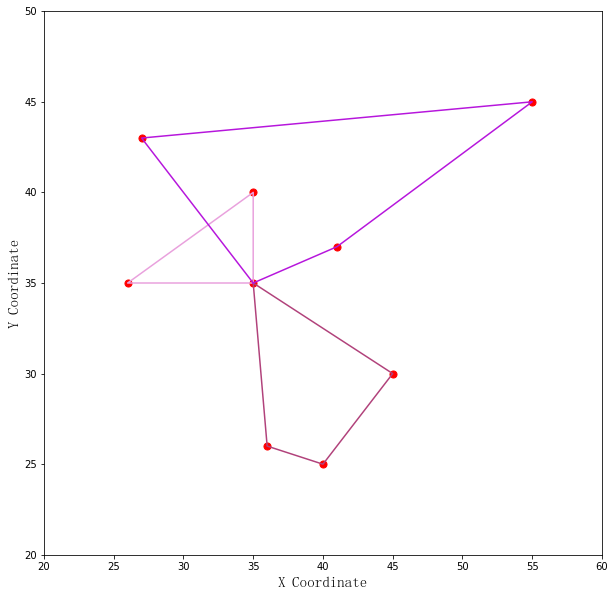

[0, 1, 6, 0, 5, 3, 4, 0, 2, 8, 7, 0] [420, 425, 430]
peak memory: 134.35 MiB, increment: 6.31 MiB


In [19]:
%%memit   #在想要测量内存使用的代码单元上方，添加%%memit魔法命令。这个命令会运行代码单元，并在执行完毕后显示内存使用的相关信息。
BP,BD = CVRP_SA()
end_time = datetime.datetime.now()  
print(BP,BD)


In [20]:
# 计算时间差，并转换为秒  
elapsed_time = (end_time - start_time).total_seconds()
# 打印执行时间  
print("执行时间: {:.2f} 秒".format(elapsed_time))

执行时间: 506.55 秒


In [22]:
path = [0, 1, 6, 0, 5, 3, 4, 0, 2, 8, 7, 0] 
departTime = [420, 425, 430]

TC = total_cost_object(path,departTime)
QDC,FC,TTime = separate_cost_object(path,departTime)

print('总成本为：',TC)
print('质量衰减成本为：',QDC)

print('燃油成本为：',FC)

总成本为： 236.22320097446755
质量衰减成本为： 236.22320097446755
燃油成本为： 193.17515272658278


In [ ]:
总成本为： 236.22320097446755
质量衰减成本为： 236.22320097446755
燃油成本为： 193.17515272658278
